In [1]:
import tensorflow as tf
import numpy as np
import cv2
import zipfile
import os
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19


In [ ]:
# 1. Ekstrak Data.zip
#with zipfile.ZipFile('C:/Dataset.zip', 'r') as zip_ref:
    #zip_ref.extractall('Dataset')


In [12]:
# Path ke file ZIP dan direktori tujuan
zip_path = 'C:/Image.zip'
Dataset = './Dataset'

# Jika direktori dataset sudah ada, hapus dan buat ulang
if os.path.exists(Dataset):
    shutil.rmtree(Dataset)  # Hapus direktori lama
os.makedirs(Dataset, exist_ok=True)  # Buat ulang direktori

# Ekstrak data dari file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(Dataset)


In [2]:
classes = [
    'Acne',
    'Actinic Cheilitis',
    'Actinic Keratosis',
    'Atopic Dermatitis',
    'Basall Cell Carcinoma',
    'Bullous Disease',
    'Cacar Air',
    'Eczema',
    'Infeksi Jamur',
    'Kutil',
    'Lupus',
    'Nail Disease',
    'Penyakit Menular Seksual',
    'Skin Cancer',
    'Urticaria Hives',
    'Vascular Tumors',
    'Vasculitis Photos',
    'Viral Infections'
]

In [ ]:
# Direktori asli dataset
dataset_dir = Dataset  # Path dari variabel sebelumnya

# Direktori untuk train dan test
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Hapus dan buat ulang direktori train dan test jika sudah ada
if os.path.exists(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)
if os.path.exists(TEST_DIR):
    shutil.rmtree(TEST_DIR)

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Bagi dataset menjadi train dan test
for label in classes:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.exists(label_dir):
        files = os.listdir(label_dir)
        train_files, test_files = train_test_split(
            files, test_size=0.1, random_state=42
        )

        # Buat subdirektori untuk train dan test per label
        os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

        # Salin file ke direktori train
        for file in train_files:
            src = os.path.join(label_dir, file)
            dst = os.path.join(TRAIN_DIR, label, file)
            shutil.copy(src, dst)

        # Salin file ke direktori test
        for file in test_files:
            src = os.path.join(label_dir, file)
            dst = os.path.join(TEST_DIR, label, file)
            shutil.copy(src, dst)

print("Dataset berhasil dibagi menjadi train dan test.")


Dataset berhasil dibagi menjadi train dan test.


In [3]:
import pandas as pd
TRAIN_DIR = './Dataset/train'
TEST_DIR = './Dataset/test'

# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)



                     Disease  Train  Test
0                       Acne    171    19
1          Actinic Cheilitis     49     6
2          Actinic Keratosis     90    10
3          Atopic Dermatitis    447    50
4      Basall Cell Carcinoma    190    22
5            Bullous Disease    396    45
6                  Cacar Air    153    17
7                     Eczema   1337   149
8              Infeksi Jamur   1333   149
9                      Kutil   1359   151
10                     Lupus     69     8
11              Nail Disease    976   109
12  Penyakit Menular Seksual    344    39
13               Skin Cancer    461    52
14           Urticaria Hives    213    24
15           Vascular Tumors    506    57
16         Vasculitis Photos    442    50
17          Viral Infections   1104   123


In [23]:
def blur_watermark(image_path, output_path):
    """
    Memburamkan area watermark secara otomatis dengan lebar 2/4 bagian
    dan tinggi 1/5 bagian di tengah gambar.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"File {image_path} tidak dapat dimuat.")

    h, w, _ = image.shape

    # Tentukan area blur
    center_y, center_x = h // 2, w // 2
    box_h = h // 5  # Tinggi blur 1/5 bagian
    box_w = w // 2  # Lebar blur 2/4 bagian (setengah lebar gambar)
    y_min = max(center_y - box_h // 2, 0)
    y_max = min(center_y + box_h // 2, h)
    x_min = max(center_x - box_w // 2, 0)
    x_max = min(center_x + box_w // 2, w)

    # Blur area di tengah
    watermark_region = image[y_min:y_max, x_min:x_max]
    blurred_region = cv2.GaussianBlur(watermark_region, (21, 21), 0)
    image[y_min:y_max, x_min:x_max] = blurred_region

    cv2.imwrite(output_path, image)

def preprocess_dataset(input_dir, output_dir):
    """
    Memburamkan watermark di dataset. Mendukung folder dengan subfolder kategori.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)

        if not os.path.isdir(class_input_dir):
            print(f"Skipping non-folder: {class_input_dir}")
            continue

        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        for image_name in os.listdir(class_input_dir):
            image_path = os.path.join(class_input_dir, image_name)
            output_path = os.path.join(class_output_dir, image_name)

            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {image_path}")
                continue

            try:
                blur_watermark(image_path, output_path)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

# Hapus hasil sebelumnya
output_dir = './Processed'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Folder {output_dir} berhasil dihapus.")

# Proses ulang dataset
preprocess_dataset('./Dataset/train', './Processed/train')
preprocess_dataset('./Dataset/test', './Processed/test')

print("Proses blur selesai.")

Folder ./Processed berhasil dihapus.
Proses blur selesai.


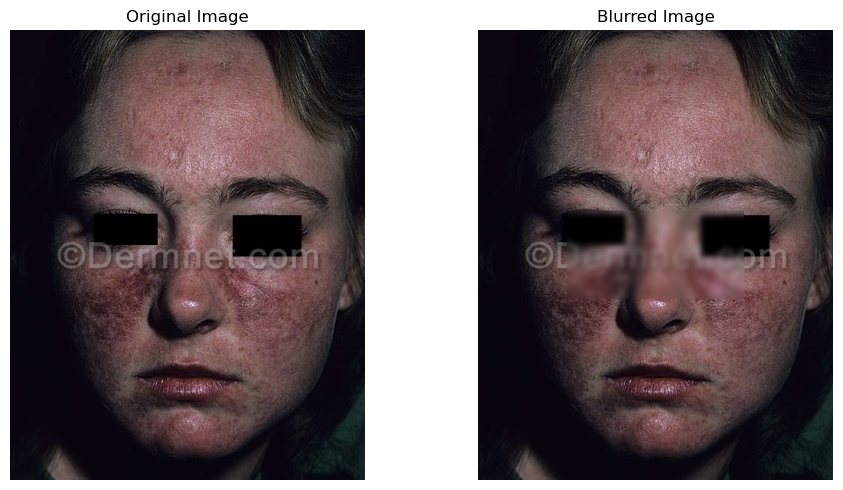

In [24]:
import matplotlib.pyplot as plt

def show_blurred_image(original_path, blurred_path):
    """
    Menampilkan gambar asli dan hasil blur secara berdampingan.
    """
    # Muat gambar asli dan hasil blur
    original_image = cv2.imread(original_path)
    blurred_image = cv2.imread(blurred_path)
    
    if original_image is None or blurred_image is None:
        raise ValueError("Salah satu gambar tidak dapat dimuat.")
    
    # Konversi warna dari BGR ke RGB untuk ditampilkan di matplotlib
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    blurred_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)
    
    # Plot gambar
    plt.figure(figsize=(10, 5))
    
    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    
    # Gambar yang diburamkan
    plt.subplot(1, 2, 2)
    plt.imshow(blurred_image)
    plt.title("Blurred Image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
original_image_path = './Dataset/train/Lupus/lupus-acute-9.jpg'  
blurred_image_path = './Processed/train/Lupus/lupus-acute-9.jpg'  

show_blurred_image(original_image_path, blurred_image_path)


In [ ]:
# Fungsi untuk menyeimbangkan data dengan augmentasi
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'
def balance_data(dataset_dir, target_count=5000):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)
        
        # Hitung jumlah gambar yang perlu dibuat  
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")
            
            # Iterasi melalui gambar hingga jumlah target terpenuhi
            generated_count = 0
            for image_file in images:
                if generated_count >= images_to_generate:  # Jika jumlah target sudah tercapai, hentikan
                    break
                
                img_path = os.path.join(class_dir, image_file)
                img = tf.keras.utils.load_img(img_path)
                img_array = tf.keras.utils.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array, 
                    batch_size=1,   
                    save_to_dir=class_dir, 
                    save_prefix='aug', 
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai

# Seimbangkan data pelatihan
balance_data(TRAIN_DIR)


Augmentasi 4829 gambar untuk kelas: Acne
Augmentasi 4951 gambar untuk kelas: Actinic Cheilitis
Augmentasi 4910 gambar untuk kelas: Actinic Keratosis
Augmentasi 4553 gambar untuk kelas: Atopic Dermatitis
Augmentasi 4810 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 4604 gambar untuk kelas: Bullous Disease
Augmentasi 4847 gambar untuk kelas: Cacar Air
Augmentasi 3663 gambar untuk kelas: Eczema
Augmentasi 3667 gambar untuk kelas: Infeksi Jamur
Augmentasi 3641 gambar untuk kelas: Kutil
Augmentasi 4930 gambar untuk kelas: Lupus
Augmentasi 4024 gambar untuk kelas: Nail Disease
Augmentasi 4656 gambar untuk kelas: Penyakit Menular Seksual
Augmentasi 4539 gambar untuk kelas: Skin Cancer
Augmentasi 4787 gambar untuk kelas: Urticaria Hives
Augmentasi 4494 gambar untuk kelas: Vascular Tumors
Augmentasi 4558 gambar untuk kelas: Vasculitis Photos
Augmentasi 3896 gambar untuk kelas: Viral Infections


In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

def balance_data(dataset_dir, target_count=5000):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    classes = os.listdir(dataset_dir)
    
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)
        
        # Hitung jumlah gambar yang perlu dibuat  
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")
            
            # Iterasi melalui gambar hingga jumlah target terpenuhi
            generated_count = 0
            for image_file in images:
                if generated_count >= images_to_generate:  # Jika jumlah target sudah tercapai, hentikan
                    break
                
                img_path = os.path.join(class_dir, image_file)
                img = tf.keras.utils.load_img(img_path)
                img_array = tf.keras.utils.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array, 
                    batch_size=1,   
                    save_to_dir=class_dir, 
                    save_prefix=f"aug_{cls}",  # Tambahkan prefix khusus berdasarkan nama kelas
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai


# Seimbangkan data pelatihan
balance_data(TRAIN_DIR)

Augmentasi 4829 gambar untuk kelas: Acne
Augmentasi 4951 gambar untuk kelas: Actinic Cheilitis
Augmentasi 4910 gambar untuk kelas: Actinic Keratosis
Augmentasi 4553 gambar untuk kelas: Atopic Dermatitis
Augmentasi 4810 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 4604 gambar untuk kelas: Bullous Disease
Augmentasi 4847 gambar untuk kelas: Cacar Air
Augmentasi 3663 gambar untuk kelas: Eczema
Augmentasi 3667 gambar untuk kelas: Infeksi Jamur
Augmentasi 3641 gambar untuk kelas: Kutil
Augmentasi 4931 gambar untuk kelas: Lupus
Augmentasi 4024 gambar untuk kelas: Nail Disease
Augmentasi 4656 gambar untuk kelas: Penyakit Menular Seksual
Augmentasi 4539 gambar untuk kelas: Skin Cancer
Augmentasi 4787 gambar untuk kelas: Urticaria Hives
Augmentasi 4494 gambar untuk kelas: Vascular Tumors
Augmentasi 4558 gambar untuk kelas: Vasculitis Photos
Augmentasi 3896 gambar untuk kelas: Viral Infections


In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def show_augmented_samples(dataset_dir, class_name, sample_to_display=5):
    """
    Menampilkan gambar hasil augmentasi dari folder tertentu.
    """
    class_dir = os.path.join(dataset_dir, class_name)
    augmented_images = [f for f in os.listdir(class_dir) if f.startswith('aug')]
    
    if not augmented_images:
        print(f"Tidak ada gambar augmentasi ditemukan di kelas: {class_name}")
        return
    
    print(f"Menampilkan {min(sample_to_display, len(augmented_images))} gambar hasil augmentasi untuk kelas: {class_name}")
    for i, image_file in enumerate(augmented_images[:sample_to_display]):
        img_path = os.path.join(class_dir, image_file)
        img = tf.keras.utils.load_img(img_path)
        
        plt.figure()
        plt.imshow(img)
        plt.title(f"Augmented Image {i+1} - Class: {class_name}")
        plt.axis('off')
    plt.show()

Menampilkan 3 gambar hasil augmentasi untuk kelas: Skin Cancer


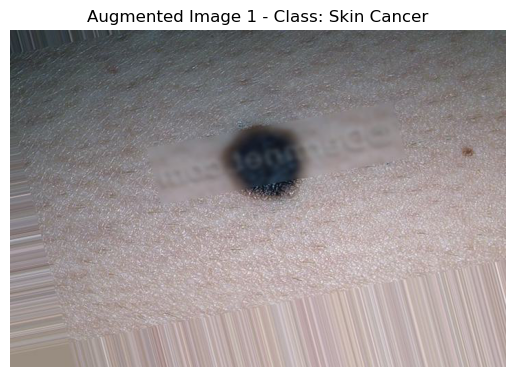

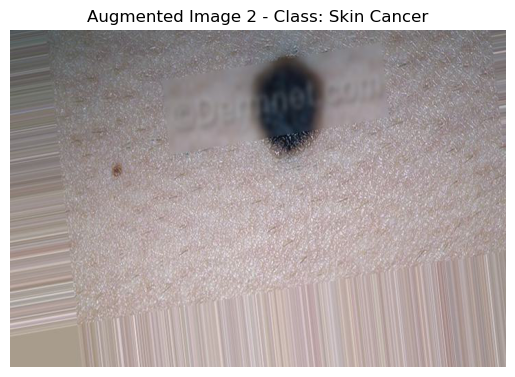

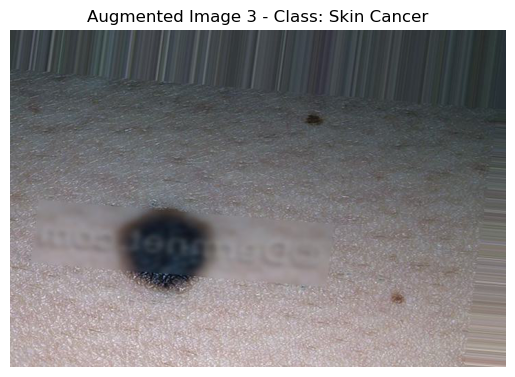

In [32]:
show_augmented_samples(TRAIN_DIR, class_name='Skin Cancer', sample_to_display=3)

In [34]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

def balance_data(dataset_dir, target_count=500):
    """
    Menyeimbangkan jumlah data dalam setiap kelas menggunakan augmentasi gambar.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    classes = os.listdir(dataset_dir)
    
    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        images = os.listdir(class_dir)
        
        # Hitung jumlah gambar yang perlu dibuat  
        if len(images) < target_count:
            images_to_generate = target_count - len(images)
            print(f"Augmentasi {images_to_generate} gambar untuk kelas: {cls}")
            
            # Iterasi melalui gambar hingga jumlah target terpenuhi
            generated_count = 0
            for image_file in images:
                if generated_count >= images_to_generate:  # Jika jumlah target sudah tercapai, hentikan
                    break
                
                img_path = os.path.join(class_dir, image_file)
                img = tf.keras.utils.load_img(img_path)
                img_array = tf.keras.utils.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                # Augmentasi gambar
                for batch in datagen.flow(
                    img_array, 
                    batch_size=1,   
                    save_to_dir=class_dir, 
                    save_prefix=f"aug_{cls}",  # Tambahkan prefix khusus berdasarkan nama kelas
                    save_format='jpeg'
                ):
                    generated_count += 1
                    if generated_count >= images_to_generate:
                        break  # Hentikan jika jumlah target tercapai


# Seimbangkan data pelatihan
balance_data(TEST_DIR)

Augmentasi 481 gambar untuk kelas: Acne
Augmentasi 494 gambar untuk kelas: Actinic Cheilitis
Augmentasi 490 gambar untuk kelas: Actinic Keratosis
Augmentasi 450 gambar untuk kelas: Atopic Dermatitis
Augmentasi 478 gambar untuk kelas: Basall Cell Carcinoma
Augmentasi 455 gambar untuk kelas: Bullous Disease
Augmentasi 483 gambar untuk kelas: Cacar Air
Augmentasi 351 gambar untuk kelas: Eczema
Augmentasi 351 gambar untuk kelas: Infeksi Jamur
Augmentasi 349 gambar untuk kelas: Kutil
Augmentasi 492 gambar untuk kelas: Lupus
Augmentasi 391 gambar untuk kelas: Nail Disease
Augmentasi 461 gambar untuk kelas: Penyakit Menular Seksual
Augmentasi 448 gambar untuk kelas: Skin Cancer
Augmentasi 476 gambar untuk kelas: Urticaria Hives
Augmentasi 443 gambar untuk kelas: Vascular Tumors
Augmentasi 450 gambar untuk kelas: Vasculitis Photos
Augmentasi 377 gambar untuk kelas: Viral Infections


Menampilkan 3 gambar hasil augmentasi untuk kelas: Skin Cancer


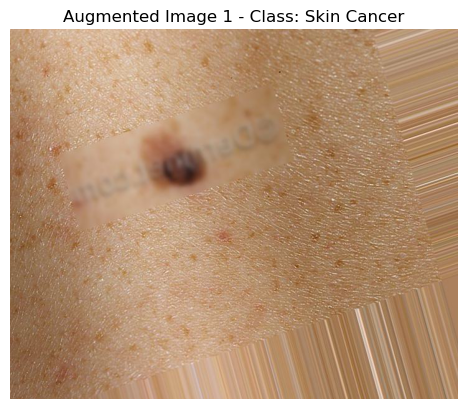

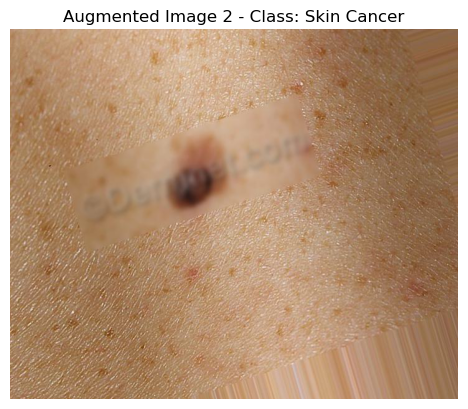

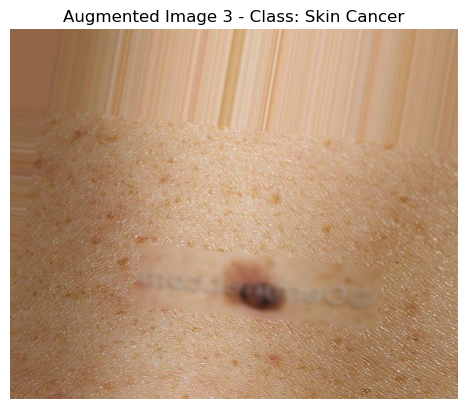

In [35]:
show_augmented_samples(TEST_DIR, class_name='Skin Cancer', sample_to_display=3)

In [4]:
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'
# Membuat daftar jumlah data untuk setiap label
data_summary = []

for disease in classes:
    train_path = os.path.join(TRAIN_DIR, disease)
    test_path = os.path.join(TEST_DIR, disease)

    train_count = len(os.listdir(train_path)) if os.path.exists(train_path) else 0
    test_count = len(os.listdir(test_path)) if os.path.exists(test_path) else 0

    data_summary.append({'Disease': disease, 'Train': train_count, 'Test': test_count})

# Membuat tabel menggunakan pandas
df_summary = pd.DataFrame(data_summary)

# Menampilkan tabel
print(df_summary)


                     Disease  Train  Test
0                       Acne   4052   492
1          Actinic Cheilitis   3913   488
2          Actinic Keratosis   3949   488
3          Atopic Dermatitis   4090   488
4      Basall Cell Carcinoma   3981   482
5            Bullous Disease   4089   493
6                  Cacar Air   4005   489
7                     Eczema   4426   493
8              Infeksi Jamur   4414   493
9                      Kutil   4417   492
10                     Lupus   3982   486
11              Nail Disease   4294   496
12  Penyakit Menular Seksual   4072   488
13               Skin Cancer   4137   494
14           Urticaria Hives   4023   487
15           Vascular Tumors   4160   487
16         Vasculitis Photos   4119   484
17          Viral Infections   4337   496


In [12]:
from PIL import Image

def is_valid_image(image_path):
    """
    Memeriksa apakah file adalah gambar yang valid.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verifikasi file gambar
        return True
    except (IOError, SyntaxError):
        return False

def clean_non_image_files(directory):
    """
    Menghapus file non-gambar di dalam folder dan subfolder.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) or not is_valid_image(file_path):
                print(f"Deleting non-image file: {file_path}")
                os.remove(file_path)

# Bersihkan dataset train dan test
clean_non_image_files('./Processed/train')
clean_non_image_files('./Processed/test')

print("File non-gambar telah dihapus.")


Deleting non-image file: ./Processed/train\Viral Infections\aug_0_1006.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_1458.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_1926.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_2412.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_2414.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_2425.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_2791.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_3072.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_325.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_3917.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_4538.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_5041.jpeg
Deleting non-image file: ./Processed/train\Viral Infections\aug_0_5637.jpeg
Deleting non-

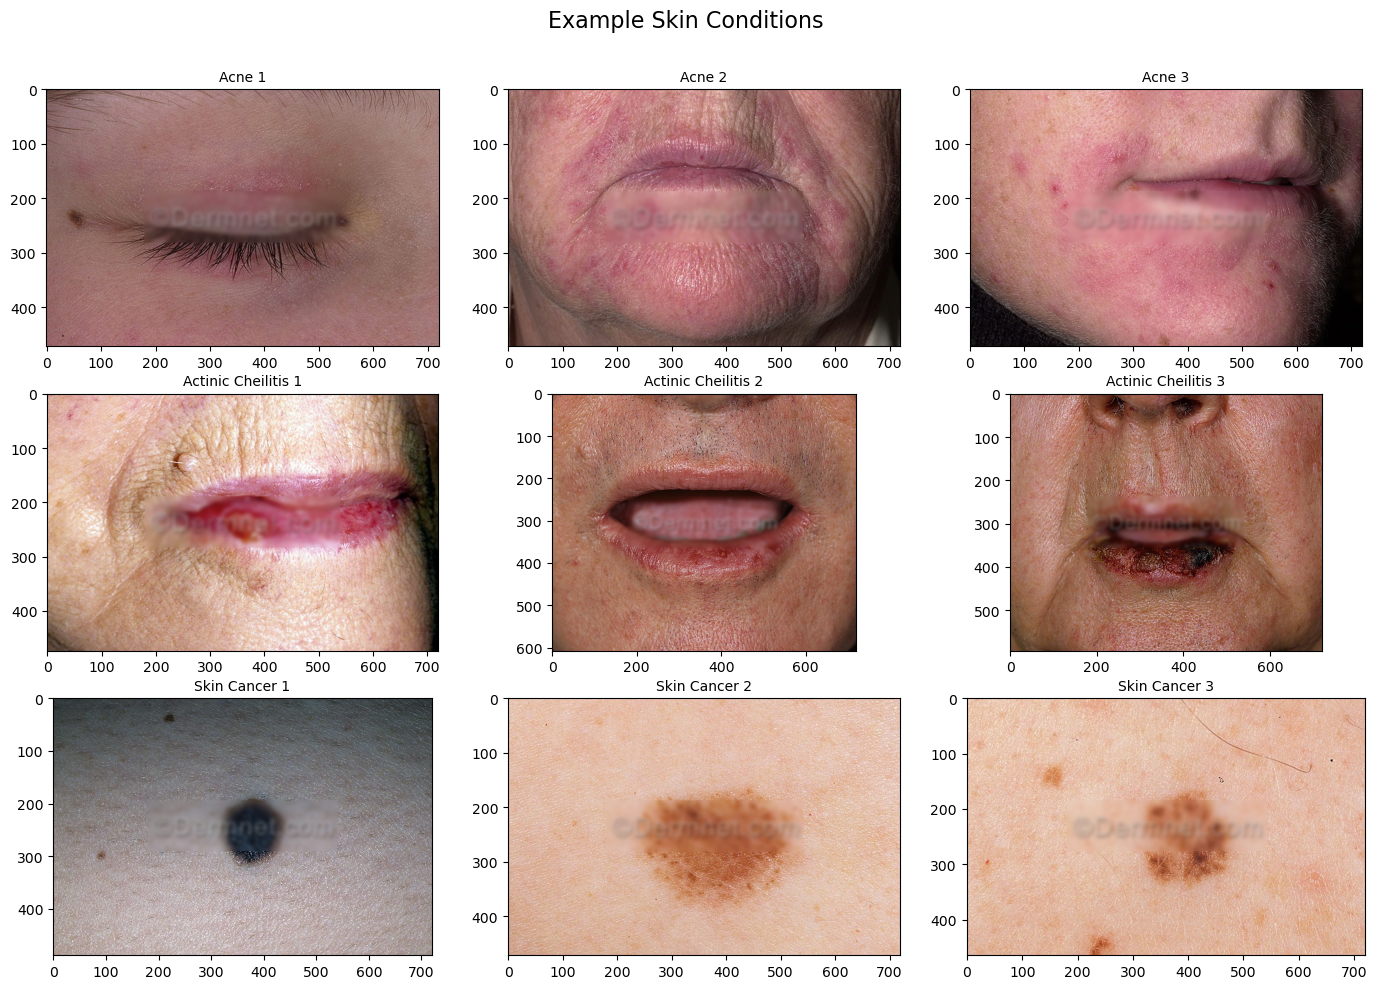

In [37]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# Direktori kategori gambar
categories = [
    "./Processed/train/Acne",
    "./Processed/train/Actinic Cheilitis",
    "./Processed/train/Skin Cancer",
]

# Jumlah gambar per kategori yang ditampilkan
num_images_per_category = 3

# Membuat grid plot
fig, axes = plt.subplots(len(categories), num_images_per_category, figsize=(14, 10))
fig.suptitle('Example Skin Conditions', fontsize=16)

# Menampilkan gambar untuk setiap kategori
for row, category in enumerate(categories):
    files = [os.path.join(category, f) for f in os.listdir(category)[:num_images_per_category]]
    for col, img_path in enumerate(files):
        img = tf.keras.utils.load_img(img_path)
        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(f"{os.path.basename(category)} {col + 1}", fontsize=10)
        ax.axis('on')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [5]:
# Path direktori data hasil blur
TRAIN_DIR = './Processed/train'
TEST_DIR = './Processed/test'

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    image_size=(180, 180),
    batch_size=32,
    label_mode="int"
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    image_size=(180, 180),
    batch_size=32,
    label_mode="int"
)

# Menstandarisasi dataset
from tensorflow.keras.layers import Rescaling
normalization_layer = Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 74460 files belonging to 18 classes.
Found 8816 files belonging to 18 classes.


In [6]:
# 4. Muat model VGG19 pretrained, tanpa top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False  # Bekukan semua lapisan di model VGG19


In [7]:
# 5. Buat model klasifikasi dengan VGG19 sebagai fitur extractor
def create_transfer_learning_model():
    """Membuat model klasifikasi transfer learning dengan VGG19 sebagai fitur extractor."""
    model = models.Sequential([
        layers.Flatten(input_shape=(180, 180, 3)),  # Flatten the image (height, width, channels)
        layers.Dense(200, activation='relu'),
        layers.Dense(170, activation='relu'),
        layers.Dense(18, activation='softmax'),
    ])

    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Inisialisasi model
model = create_transfer_learning_model()

#summary model
model.summary()

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │      19,440,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 170)                 │          34,170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,477,448 (74.30 MB)

 Trainable params: 19,477,448 (74.30 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 5. Buat model klasifikasi dengan VGG19 sebagai fitur extractor
def create_transfer_learning_model():
    """Membuat model klasifikasi transfer learning dengan VGG19 sebagai fitur extractor."""
    model = models.Sequential([
        base_model,
        layers.Flatten(input_shape=(180, 180, 3)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')  # Output layer sesuai jumlah kelas
    ])

    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Inisialisasi model
model = create_transfer_learning_model()

#summary model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 5, 5, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,306,066 (88.91 MB)

 Trainable params: 3,281,682 (12.52 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [15]:
# 6. Menyiapkan callbacks untuk early stopping dan pengurangan learning rate
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('best_model_vgg19.keras', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='max')


In [16]:
# 7. Latih model
from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk menghentikan pelatihan saat akurasi mencapai 99%
early_stopping = EarlyStopping(
    monitor='accuracy',          # Ganti dengan 'val_accuracy' jika ingin validasi
    mode='max',
    baseline=0.90,               # Target akurasi 99%
    patience=0,                  # Hentikan segera
    verbose=1
)

# Pelatihan model dengan callbacks
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[checkpoint, reduce_lr, early_stopping]  # Tambahkan early stopping
)

Epoch 1/100
   8/2327 ━━━━━━━━━━━━━━━━━━━━ 2:09:51 3s/step - accuracy: 0.1260 - loss: 3.6708

KeyboardInterrupt: 

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_custom_cnn(input_shape, num_classes):
    """Membuat model CNN custom untuk klasifikasi 23 label."""
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Tambahkan Input layer di sini
        
        # Layer convolutional pertama
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Layer convolutional kedua
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Layer convolutional ketiga
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Fully connected layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Mencegah overfitting
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')  # Untuk klasifikasi 23 label
    ])
    
    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        #loss='sparse_categorical_crossentropy',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

# Parameter model
input_shape = (224, 224, 3)  # Gambar 180x180 piksel dengan 3 channel warna
num_classes = 18  # Jumlah label

# Membuat model
model = create_custom_cnn(input_shape, num_classes)

# Menampilkan summary model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,171,282 (42.62 MB)

 Trainable params: 11,171,282 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
import tensorflow as tf

# Callback untuk menghentikan pelatihan jika akurasi mencapai 90%
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.90):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Cek akurasi pada training dan validation
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        
        if train_acc and train_acc >= self.target_accuracy:
            print(f"\nAkurasi pelatihan mencapai {train_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True
        
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nAkurasi validasi mencapai {val_acc:.2f}. Pelatihan dihentikan.")
            self.model.stop_training = True

# Melatih model dengan callback custom
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,  # Anda bisa menyesuaikan jumlah epoch
    callbacks=[
        StopAtAccuracy(target_accuracy=0.90),  # Callback untuk menghentikan pelatihan jika akurasi >= 90%
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,  # Tunggu hingga 3 epoch tanpa peningkatan
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 3260s 1s/step - accuracy: 0.7063 - loss: 1.0687 - val_accuracy: 0.2450 - val_loss: 3.2323
Epoch 2/100
2327/2327 ━━━━━━━━━━━━━━━━━━━━ 1623s 697ms/step - accuracy: 0.8838 - loss: 0.4211 - val_accuracy: 0.2330 - val_loss: 3.8059
Epoch 3/100
  97/2327 ━━━━━━━━━━━━━━━━━━━━ 26:55 725ms/step - accuracy: 0.8856 - loss: 0.3811

KeyboardInterrupt: 

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss'] 
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
# 8. Muat model terbaik setelah pelatihan selesai
#model.load_weights('best_model_vgg19.h5')
